In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import numpy as np
import pandas as pd

In [29]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # add ROC AUC print 
    print('정확도 = {0:.4f}, 정밀도 = {1:.4f}, 재현율 = {2:.4f}, F1 = {3:.4f}, AUC = {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [30]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    
    return df

# 머신러닝 알고리즘에 불필요한 피처 제거 함수
def drop_unnecessary_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    
    return df

# 레이블 인코딩 수행 함수
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        encoder = LabelEncoder()
        encoder = encoder.fit(df[feature])
        df[feature] = encoder.transform(df[feature])
    
    return df

# 위 3개의 함수 호출하는 데이터 전처리 함수
def transform_features(df):
    df = fillna(df)
    df = drop_unnecessary_features(df)
    df = format_features(df)
    
    return df

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 데이터 로딩 및 전처리
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

# 학습, 테스트 데이터 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2 , random_state=11)

# 학습 및 예측 진행
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train) 
pred = lr_clf.predict(X_test)

# 평가 진행
get_clf_eval(y_test, pred, lr_clf.predict_proba(X_test)[:,1])

오차 행렬
[[108  10]
 [ 14  47]]
정확도 = 0.8659, 정밀도 = 0.8246, 재현율 = 0.7705, F1 = 0.7966, AUC = 0.8987


In [33]:
from sklearn.metrics import roc_curve

# positive일 때 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 임곗값을 5 step으로 추출
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index: ', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index:  [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값:  [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR:  [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값별 TPR:  [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


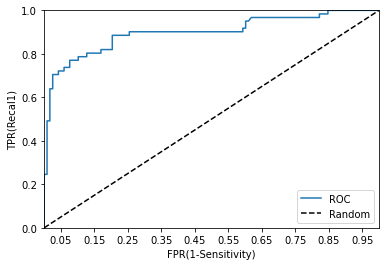

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1],[0,1], 'k--', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recal1)')

    plt.legend()

roc_curve_plot(y_test, pred_proba_class1)

In [35]:
from sklearn.metrics import roc_auc_score

roc_score = roc_auc_score(y_test, pred_proba_class1)
print('ROC AUC 값 = ', np.round(roc_score, 4))

ROC AUC 값 =  0.8987
